# May --th, 2021

**Motivation**: Allen SDK + fMRI.</br>

In [1]:
import os
import ants
import nrrd

import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
import operator as op
from os.path import join as pjoin

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from utils.processing import *

In [2]:
def trim_axs(axes, n):
    axs = axes.flat
    for ax in axs[n:]:
        ax.remove()
    return axs[:n]

## Allen Coordinate System

Here is an image embedded from their website:

> ReferenceSpace id = 9 is in PIR orientation (+x = posterior, +y = inferior, +z = right). ReferenceSpace id = 10 is identical to ReferenceSpace id = 9. The reason for the two spaces is to allow left hemisphere sagittal data to correspond to the right hemisphere coronal reference atlas. This is implemented as a z-axis flip transform between the two reference spaces for the purposes of image synchronization (see below).

> All coronal data is registered to ReferenceSpace id = 9. All sagittal data is registered to ReferenceSpace id = 10.

![Allen Coordinate Space](http://help.brain-map.org/download/attachments/5308472/3DOrientation.png?version=1&modificationDate=1368132564812&api=v2 "Allen Coordinate Space")

## Allen SDK

In [3]:
import allensdk
allensdk.__version__

'2.11.2'

In [4]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

mcc = MouseConnectivityCache(resolution=100)
structure_tree = mcc.get_structure_tree()

cerebrum = structure_tree.get_structures_by_name(['Cerebrum'])[0]
isocortex = structure_tree.get_structures_by_name(['Isocortex'])[0]
cerebrum, isocortex

({'acronym': 'CH',
  'graph_id': 1,
  'graph_order': 2,
  'id': 567,
  'name': 'Cerebrum',
  'structure_id_path': [997, 8, 567],
  'structure_set_ids': [112905828,
   691663206,
   12,
   184527634,
   112905813,
   114512891,
   114512892],
  'rgb_triplet': [176, 240, 255]},
 {'acronym': 'Isocortex',
  'graph_id': 1,
  'graph_order': 5,
  'id': 315,
  'name': 'Isocortex',
  'structure_id_path': [997, 8, 567, 688, 695, 315],
  'structure_set_ids': [2,
   112905828,
   691663206,
   12,
   184527634,
   112905813,
   687527670,
   114512891,
   114512892],
  'rgb_triplet': [112, 255, 113]})

In [98]:
cerebrum['id']

567

In [99]:
structure_tree.nodes(structure_tree.child_ids([cerebrum['id']])[0])

[{'acronym': 'CTX',
  'graph_id': 1,
  'graph_order': 3,
  'id': 688,
  'name': 'Cerebral cortex',
  'structure_id_path': [997, 8, 567, 688],
  'structure_set_ids': [112905828,
   691663206,
   12,
   184527634,
   112905813,
   114512891,
   114512892],
  'rgb_triplet': [176, 255, 184]},
 {'acronym': 'CNU',
  'graph_id': 1,
  'graph_order': 570,
  'id': 623,
  'name': 'Cerebral nuclei',
  'structure_id_path': [997, 8, 567, 623],
  'structure_set_ids': [112905828,
   691663206,
   12,
   184527634,
   112905813,
   114512891,
   114512892],
  'rgb_triplet': [152, 214, 249]}]

In [100]:
structure_tree.nodes(structure_tree.child_ids([688])[0])

[{'acronym': 'CTXpl',
  'graph_id': 1,
  'graph_order': 4,
  'id': 695,
  'name': 'Cortical plate',
  'structure_id_path': [997, 8, 567, 688, 695],
  'structure_set_ids': [112905828,
   691663206,
   12,
   184527634,
   112905813,
   114512891,
   114512892],
  'rgb_triplet': [112, 255, 112]},
 {'acronym': 'CTXsp',
  'graph_id': 1,
  'graph_order': 555,
  'id': 703,
  'name': 'Cortical subplate',
  'structure_id_path': [997, 8, 567, 688, 703],
  'structure_set_ids': [2,
   3,
   112905828,
   691663206,
   12,
   184527634,
   687527670,
   114512891],
  'rgb_triplet': [138, 218, 135]}]

In [103]:
structure_tree.nodes(structure_tree.child_ids([695])[0])

[{'acronym': 'Isocortex',
  'graph_id': 1,
  'graph_order': 5,
  'id': 315,
  'name': 'Isocortex',
  'structure_id_path': [997, 8, 567, 688, 695, 315],
  'structure_set_ids': [2,
   112905828,
   691663206,
   12,
   184527634,
   112905813,
   687527670,
   114512891,
   114512892],
  'rgb_triplet': [112, 255, 113]},
 {'acronym': 'OLF',
  'graph_id': 1,
  'graph_order': 379,
  'id': 698,
  'name': 'Olfactory areas',
  'structure_id_path': [997, 8, 567, 688, 695, 698],
  'structure_set_ids': [2,
   3,
   112905828,
   691663206,
   12,
   184527634,
   112905813,
   687527670,
   114512891,
   114512892],
  'rgb_triplet': [154, 210, 189]},
 {'acronym': 'HPF',
  'graph_id': 1,
  'graph_order': 454,
  'id': 1089,
  'name': 'Hippocampal formation',
  'structure_id_path': [997, 8, 567, 688, 695, 1089],
  'structure_set_ids': [2,
   112905828,
   691663206,
   12,
   184527634,
   112905813,
   687527670,
   114512891,
   114512892],
  'rgb_triplet': [126, 208, 75]}]

In [101]:
structure_tree.nodes(structure_tree.child_ids([623])[0])

[{'acronym': 'STR',
  'graph_id': 1,
  'graph_order': 571,
  'id': 477,
  'name': 'Striatum',
  'structure_id_path': [997, 8, 567, 623, 477],
  'structure_set_ids': [2,
   112905828,
   691663206,
   12,
   184527634,
   112905813,
   687527670,
   114512891,
   114512892],
  'rgb_triplet': [152, 214, 249]},
 {'acronym': 'PAL',
  'graph_id': 1,
  'graph_order': 608,
  'id': 803,
  'name': 'Pallidum',
  'structure_id_path': [997, 8, 567, 623, 803],
  'structure_set_ids': [2,
   112905828,
   691663206,
   12,
   184527634,
   112905813,
   687527670,
   114512891,
   114512892],
  'rgb_triplet': [133, 153, 204]}]

In [107]:
structure_tree.get_structures_by_id([997, 8, 567, 688, 695, 698])

[{'acronym': 'root',
  'graph_id': 1,
  'graph_order': 0,
  'id': 997,
  'name': 'root',
  'structure_id_path': [997],
  'structure_set_ids': [691663206],
  'rgb_triplet': [255, 255, 255]},
 {'acronym': 'grey',
  'graph_id': 1,
  'graph_order': 1,
  'id': 8,
  'name': 'Basic cell groups and regions',
  'structure_id_path': [997, 8],
  'structure_set_ids': [112905828,
   691663206,
   12,
   184527634,
   112905813,
   114512891,
   114512892],
  'rgb_triplet': [191, 218, 227]},
 {'acronym': 'CH',
  'graph_id': 1,
  'graph_order': 2,
  'id': 567,
  'name': 'Cerebrum',
  'structure_id_path': [997, 8, 567],
  'structure_set_ids': [112905828,
   691663206,
   12,
   184527634,
   112905813,
   114512891,
   114512892],
  'rgb_triplet': [176, 240, 255]},
 {'acronym': 'CTX',
  'graph_id': 1,
  'graph_order': 3,
  'id': 688,
  'name': 'Cerebral cortex',
  'structure_id_path': [997, 8, 567, 688],
  'structure_set_ids': [112905828,
   691663206,
   12,
   184527634,
   112905813,
   114512891,


In [5]:
# a list of dictionaries containing metadata for non-Cre experiments
all_experiments = mcc.get_experiments(dataframe=True)
selected_experiments = all_experiments.loc[all_experiments.structure_abbrev == 'SSp-bfd']
# experiment_id = selected_experiments.id.tolist()[1]
experiment_id = 657041814

# download the projection density volume for one of the experiments
pjd, pjd_info = mcc.get_projection_density(experiment_id)

# injection density: number of projecting pixels in injection site / voxel volume
ind, ind_info = mcc.get_injection_density(experiment_id)

# injection fraction: number of pixels in injection site / voxel volume
inf, inf_info = mcc.get_injection_fraction(experiment_id)

# binary mask indicating which voxels contain valid data
dm, dm_info = mcc.get_data_mask(experiment_id)

# template and annotation info
template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

# in addition to the annotation volume, you can get binary masks for individual structures
cerebrum_mask, cerebrum_mask_info = mcc.get_structure_mask(cerebrum['id'])
cortex_mask, cortex_mask_info = mcc.get_structure_mask(isocortex['id'])

In [6]:
all_experiments.loc[experiment_id]

gender                                                                F
injection_structures                                              [329]
injection_volume                                               0.240514
injection_x                                                        6870
injection_y                                                        1420
injection_z                                                        2270
product_id                                                           36
specimen_name                                      Emx1-IRES-Cre-363522
strain                                                             None
structure_abbrev                                                SSp-bfd
structure_id                                                        329
structure_name                 Primary somatosensory area, barrel field
transgenic_line                                           Emx1-IRES-Cre
transgenic_line_id                                          1778

In [7]:
# get info on some structures
structures = structure_tree.get_structures_by_name(['Primary visual area', 'Hypothalamus'])
pd.DataFrame(structures)

acronym  graph_id  graph_order    id                 name  \
0    VISp         1          185   385  Primary visual area   
1      HY         1          715  1097         Hypothalamus   

                        structure_id_path  \
0  [997, 8, 567, 688, 695, 315, 669, 385]   
1               [997, 8, 343, 1129, 1097]   

                                   structure_set_ids    rgb_triplet  
0  [396673091, 112905828, 688152357, 691663206, 6...  [8, 133, 140]  
1  [2, 112905828, 691663206, 12, 184527634, 11290...  [230, 68, 56]

In [8]:
oapi = OntologiesApi()

# get the ids of all the structure sets in the tree
structure_set_ids = structure_tree.get_structure_sets()

# query the API for information on those structure sets
pd.DataFrame(oapi.get_structure_sets(structure_set_ids))

description         id  \
0             List of structures in Isocortex layer 5  667481446   
1            List of structures in Isocortex layer 6b  667481450   
2                Summary structures of the cerebellum  688152368   
3      List of structures for ABA Differential Search         12   
4   List of valid structures for projection target...  184527634   
5   Structures whose surfaces are represented by a...  691663206   
6                  Summary structures of the midbrain  688152365   
7                   Summary structures of the medulla  688152367   
8                  Summary structures of the striatum  688152361   
9   Structures representing subdivisions of the mo...  687527945   
10    Summary structures of the hippocampal formation  688152359   
11  List of visual cortex structures targeted for ...  514166994   
12          Summary structures of the olfactory areas  688152358   
13  Curated list of non-overlapping substructures ...  167587189   
14            List of structures in Isocortex layer 4  667481445   
15  Structures representing the major divisions of...  687527670   
16                 Summary structures of the pallidum  688152362   
17  List of Primary injection structures for BDA/A...  114512892   
18  List of primary AND secondary injection struct...  112905813   
19   List of structures for ABA Fine Structure Search         10   
20  List of primary AND secondary injection struct...  112905828   
21           List of structures in Isocortex layer 6a  667481449   
22  List of structures representing a areal level ...          3   
23            List of structures in Isocortex layer 1  667481440   
24             Summary structures of the hypothalamus  688152364   
25          List of structures in Isocortex layer 2/3  667481441   
26                 All mouse visual areas with layers  396673091   
27        Summary structures of the cortical subplate  688152360   
28                 Summary structures of the thalamus  688152363   
29  List of structures representing a coarse level...          2   
30                Summary structures of the isocortex  688152357   
31  List of Primary injection structures for Proje...  114512891   
32                     Summary structures of the pons  688152366   

                                                 name  
0                                   Isocortex layer 5  
1                                  Isocortex layer 6b  
2                                          Cerebellum  
3                           ABA - Differential Search  
4                  Mouse Connectivity - Target Search  
5                      Mouse Brain - Has Surface Mesh  
6                                            Midbrain  
7                                             Medulla  
8                                            Striatum  
9                        Mouse Connectivity - Summary  
10                              Hippocampal Formation  
11     Allen Brain Observatory targeted structure set  
12                                    Olfactory Areas  
13                         Brain – Summary Structures  
14                                  Isocortex layer 4  
15                            Brain - Major Divisions  
16                                           Pallidum  
17  Mouse Connectivity - BDA/AAV Primary Injection...  
18  Mouse Connectivity - BDA/AAV All Injection Str...  
19                        ABA - Fine Structure Search  
20  Mouse Connectivity - Projection All Injection ...  
21                                 Isocortex layer 6a  
22                                      Mouse - Areas  
23                                  Isocortex layer 1  
24                                       Hypothalamus  
25                                Isocortex layer 2/3  
26                      Mouse Cell Types - Structures  
27                                  Cortical Subplate  
28                                           Thalamus  
29                                     Mouse - Co

In [9]:
# From the above table, "Mouse Connectivity - Summary" has id 167587189
summary_structures = structure_tree.get_structures_by_set_id([167587189])
pd.DataFrame(summary_structures)structure_set_ids

acronym  graph_id  graph_order         id  \
0             FRP         1            6        184   
1             MOp         1           18        985   
2             MOs         1           24        993   
3           SSp-n         1           44        353   
4         SSp-bfd         1           51        329   
..            ...       ...          ...        ...   
311            FN         1         1097        989   
312            IP         1         1098         91   
313            DN         1         1099        846   
314          VeCB         1         1100  589508455   
315  fiber tracts         1         1101       1009   

                                         name  \
0               Frontal pole, cerebral cortex   
1                          Primary motor area   
2                        Secondary motor area   
3            Primary somatosensory area, nose   
4    Primary somatosensory area, barrel field   
..                                        ...   
311                         Fastigial nucleus   
312                        Interposed nucleus   
313                           Dentate nucleus   
314               Vestibulocerebellar nucleus   
315                              fiber tracts   

                               structure_id_path  \
0              [997, 8, 567, 688, 695, 315, 184]   
1         [997, 8, 567, 688, 695, 315, 500, 985]   
2         [997, 8, 567, 688, 695, 315, 500, 993]   
3    [997, 8, 567, 688, 695, 315, 453, 322, 353]   
4    [997, 8, 567, 688, 695, 315, 453, 322, 329]   
..                                           ...   
311                      [997, 8, 512, 519, 989]   
312                       [997, 8, 512, 519, 91]   
313                      [997, 8, 512, 519, 846]   
314                [997, 8, 512, 519, 589508455]   
315                                  [997, 1009]   

                                     structure_set_ids      rgb_triplet  
0    [3, 112905828, 688152357, 691663206, 687527945...    [38, 143, 69]  
1    [112905828, 688152357, 691663206, 687527945, 1...    [31, 157, 90]  
2    [112905828, 688152357, 691663206, 687527945, 1...    [31, 157, 90]  
3    [112905828, 688152357, 691663206, 687527945, 1...   [24, 128, 100]  
4    [112905828, 688152357, 691663206, 687527945, 1...   [24, 128, 100]  
..                                                 ...              ...  
311  [112905828, 691663206, 687527945, 12, 68815236...  [255, 253, 188]  
312  [112905828, 691663206, 687527945, 12, 68815236...  [255, 253, 188]  
313  [112905828, 691663206, 687527945, 12, 68815236...  [255, 253, 188]  
314  [112905828, 691663206, 688152368, 184527634, 1...  [255, 253, 188]  
315       [687527945, 184527634, 167587189, 691663206]  [204, 204, 204]  

[316 rows x 8 columns]

### Summary plot

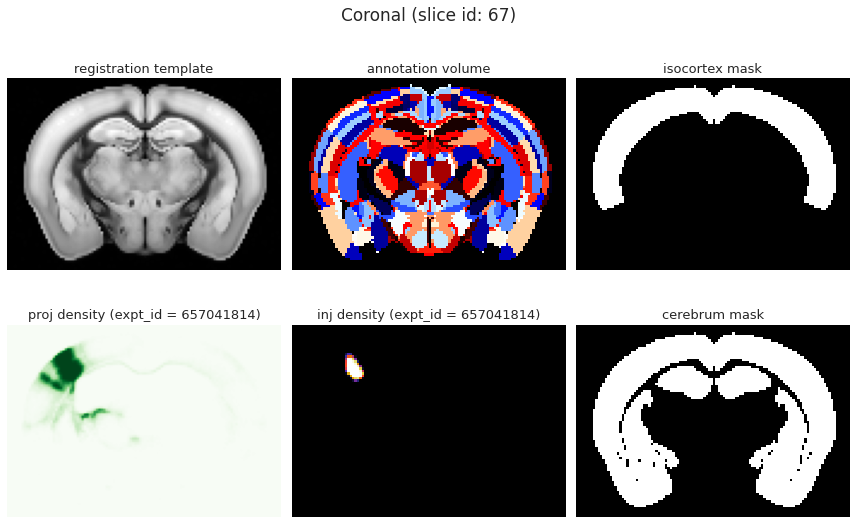

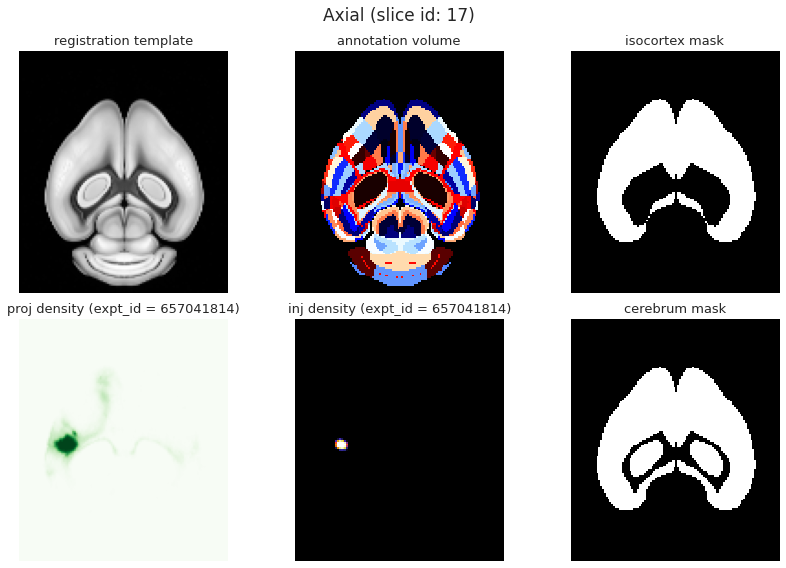

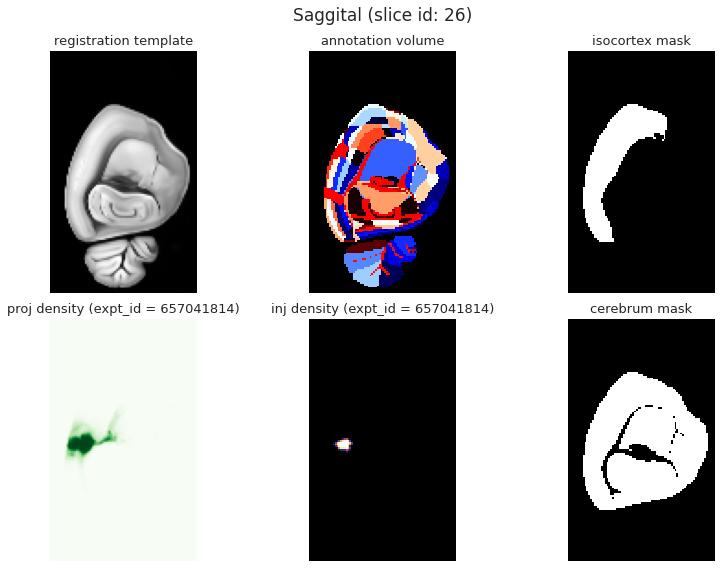

In [10]:
dims = {0: 'Coronal', 1: 'Axial', 2: 'Saggital'}

for dim, name in dims.items():
    if dim == 0:
        slice_idx =  np.argmax(np.abs(pjd).mean(-1).mean(-1))
    elif dim == 1:
        slice_idx =  np.argmax(np.abs(pjd).mean(-1).mean(0))
    else:
        slice_idx =  np.argmax(np.abs(pjd).mean(0).mean(0))
    
    nrows, ncols = 2, 3
    fig, ccf_axes = plt.subplots(nrows, ncols, figsize=(12, 8))

    for i in range(nrows):
        for j in range(ncols):

            interpolation = 'none'
            vmin, vmax = None, None

            if (i, j) == (0, 0):
                data2plt = template.take(slice_idx, axis=dim)
                cmap = 'Greys_r'
                interpolation = 'antialiased'
                title = 'registration template'

            elif (i, j) == (0, 1):
                data2plt = annot.take(slice_idx, axis=dim)
                cmap = 'flag_r'
                title = 'annotation volume'
                vmin = 0
                vmax = 2000

            elif (i, j) == (0, 2):
                data2plt = cortex_mask.take(slice_idx, axis=dim)
                cmap = 'Greys_r'
                title = 'isocortex mask'

            elif (i, j) == (1, 0):
                data2plt = pjd.take(slice_idx, axis=dim)
                cmap = 'Greens'
                interpolation = 'antialiased'
                title = 'proj density (expt_id = {:d})'.format(experiment_id)

            elif (i, j) == (1, 1):
                data2plt = ind.take(slice_idx, axis=dim)
                cmap = 'CMRmap'
                title = 'inj density (expt_id = {:d})'.format(experiment_id)
            else:
                data2plt = cerebrum_mask.take(slice_idx, axis=dim)
                cmap = 'Greys_r'
                title = 'cerebrum mask'

            # apply mask
            data2plt = data2plt.astype(float)
            data2plt *= dm.take(slice_idx, axis=dim)


            ccf_axes[i, j].imshow(
                X=data2plt,
                cmap=cmap,
                aspect='equal',
                interpolation=interpolation,
                vmin=vmin,
                vmax=vmax,
            )
            ccf_axes[i, j].set_title(title, fontsize=13)
            ccf_axes[i, j].axis('off')

    fig.suptitle("{:s} (slice id: {:d})".format(name, slice_idx), fontsize=17)
    fig.tight_layout()
    plt.show()
    
    print('\n')

### Isocortex mask

In [11]:
isocortex

{'acronym': 'Isocortex',
 'graph_id': 1,
 'graph_order': 5,
 'id': 315,
 'name': 'Isocortex',
 'structure_id_path': [997, 8, 567, 688, 695, 315],
 'structure_set_ids': [2,
  112905828,
  691663206,
  12,
  184527634,
  112905813,
  687527670,
  114512891,
  114512892],
 'rgb_triplet': [112, 255, 113]}

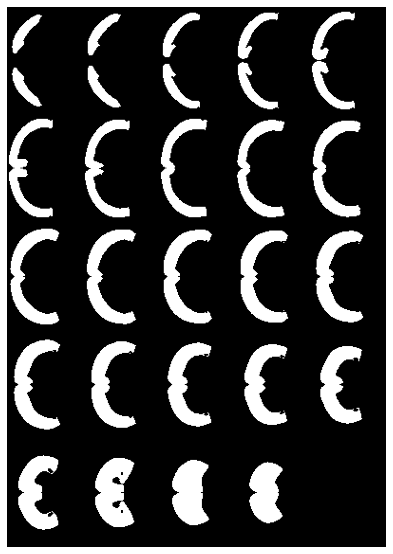

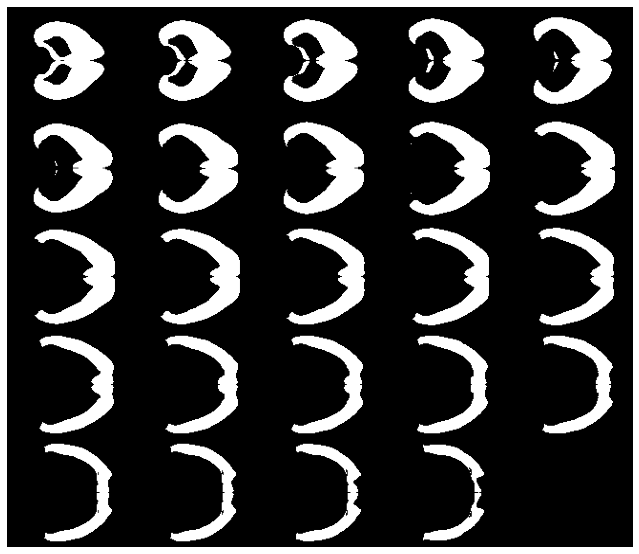

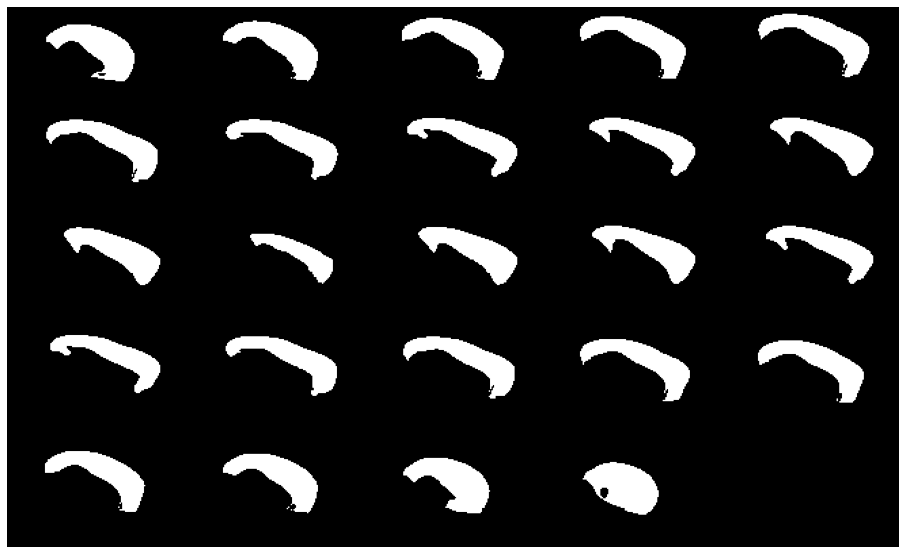

In [12]:
for dim in dims:
    ants.from_numpy(cortex_mask).plot(axis=dim, nslices=24)

### Cerebrum mask

In [13]:
cerebrum

{'acronym': 'CH',
 'graph_id': 1,
 'graph_order': 2,
 'id': 567,
 'name': 'Cerebrum',
 'structure_id_path': [997, 8, 567],
 'structure_set_ids': [112905828,
  691663206,
  12,
  184527634,
  112905813,
  114512891,
  114512892],
 'rgb_triplet': [176, 240, 255]}

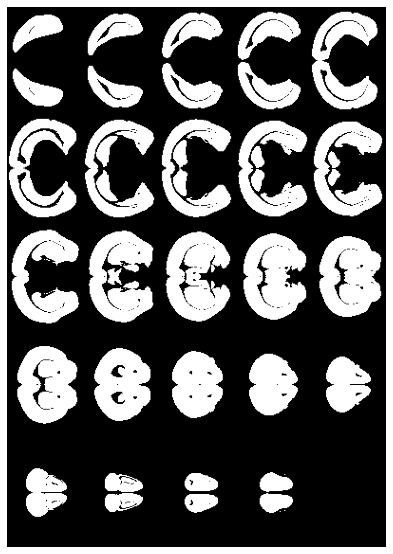

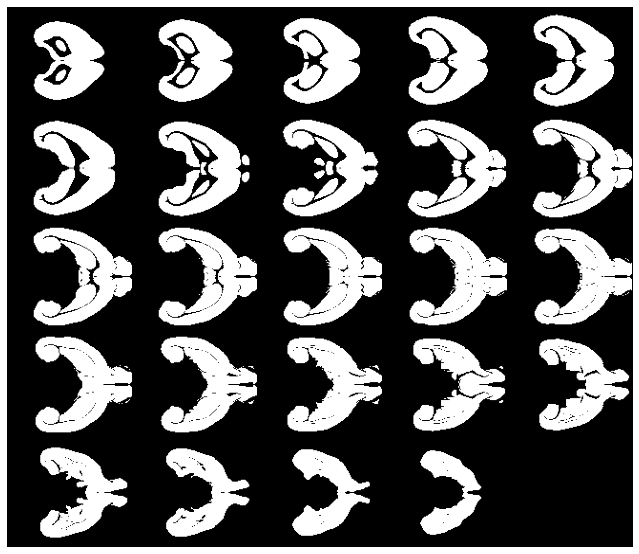

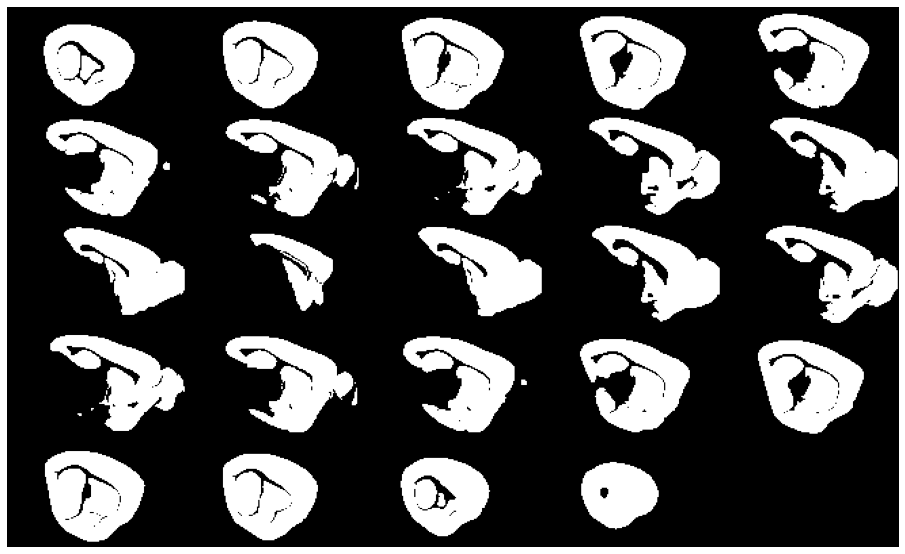

In [14]:
for dim in dims:
    ants.from_numpy(cerebrum_mask).plot(axis=dim, nslices=24)

## Spatial normalization using ANTs

In [18]:
config = Config()

# func = {}
for subject in tqdm(range(1, config.num_subjects+1), leave=False):
    for session in tqdm(range(1, config.num_sessions+1), leave=False):
        if subject != 6 or session != 1:
            continue
            
        keywords = [
            'sub-SLC{:02d}'.format(subject),
            'ses-{:d}'.format(session),
            'space-individual',
        ]
                
        # func
        # for run in range(1, config.num_runs+1):
        #     kws_func = keywords + ['run-{:d}'.format(run), 'task-rest', 'bold']
        #     gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_func))
        #     try:
        #         func_file = pjoin(config.raw_dir, next(gen))
        #     except StopIteration:
        #         continue
        #     func[run] = ants.image_read(func_file, reorient='SAR')
        
        # anat
        kws_anat = keywords + ['T1w']
        gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_anat))
        anat_file = pjoin(config.raw_dir, next(gen))
        
        # mask
        kws_mask = keywords + ['desc-mask', 'bold']
        gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_mask))
        mask_file = pjoin(config.raw_dir, next(gen))
        
        # load anat and mask and reorient
        moving = ants.image_read(anat_file, reorient='SAR')
        mask = ants.image_read(mask_file, reorient='SAR')
        
        moving *= mask
        mask = moving.get_mask()
        
# reference image
CH_mask = ants.from_numpy(cerebrum_mask.astype(float), origin=(0, 0, 0))
fixed = ants.from_numpy(template.astype(float), origin=(0, 0, 0))
fixed, CH_mask = [ants.resample_image(img, [2] * 3) for img in [fixed, CH_mask]]

moving, mask, fixed, CH_mask = list(
    ants.from_numpy(img.numpy().astype(float), origin=(0, 0, 0))
    for img in [moving, mask, fixed, CH_mask]
)

moving.shape, mask.shape, fixed.shape

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

((78, 64, 64), (78, 64, 64), (66, 40, 57))

### Register

In [19]:
tx = ants.registration(
    fixed=fixed,
    moving=moving,
    mask=mask,
    type_of_transform='SyN',
    verbose=True,
)

In [20]:
warped = ants.apply_transforms(
    fixed=fixed,
    moving=moving,
    transformlist=tx['fwdtransforms'],
    interpolator='linear',
)
warped

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (66, 40, 57)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

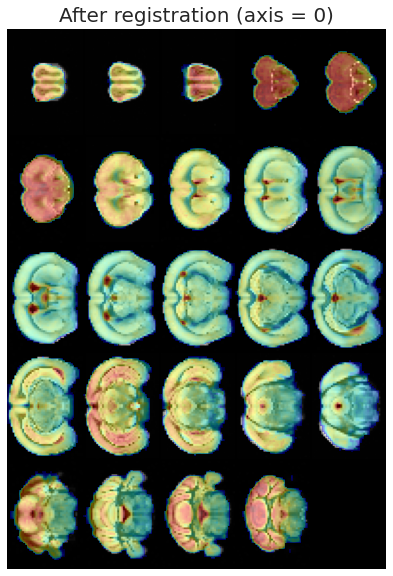

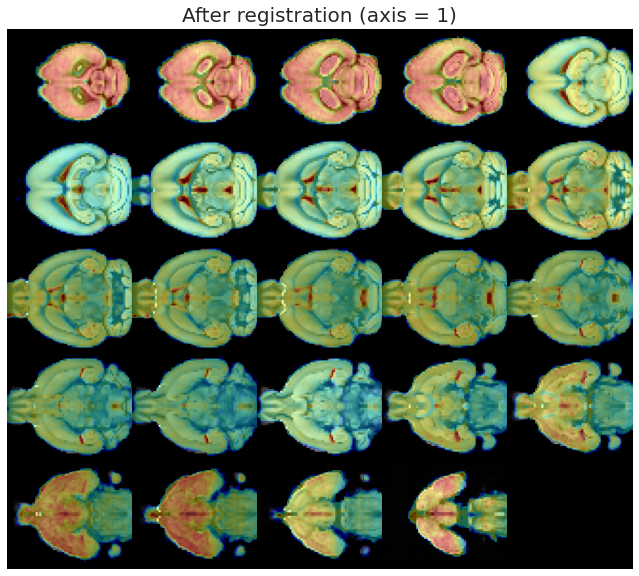

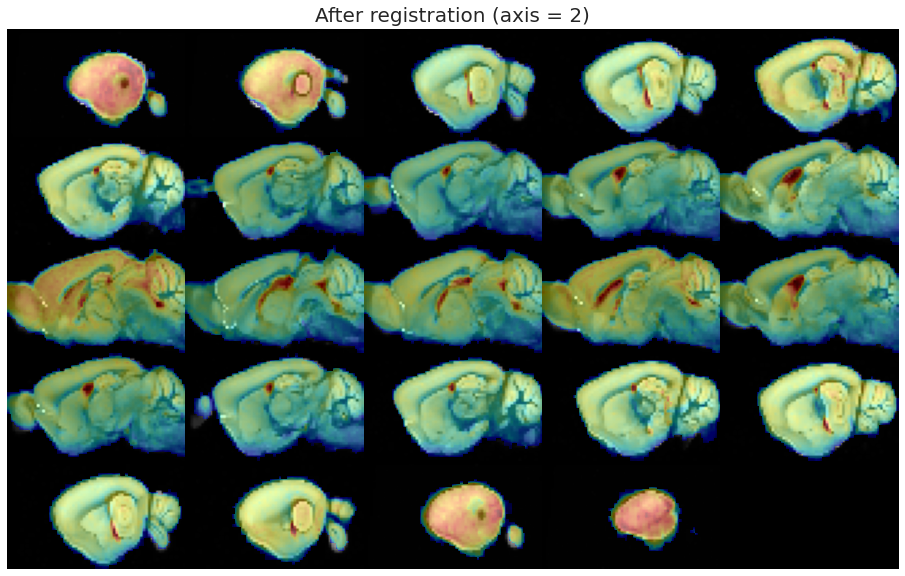

In [21]:
for axis in range(3):
    fixed.plot(
        overlay=warped,
        nslices=24,
        overlay_alpha=0.4,
        axis=axis,
        figsize=1.5,
        reorient=False,
        title='After registration (axis = {:d})'.format(axis),
    )

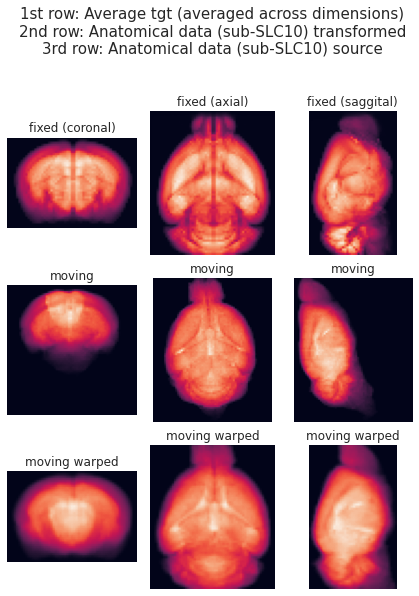

In [22]:
sns.set_style('white')
fig, axes = plt.subplots(3, 3, figsize=(6, 8))

for i in range(3):
    for j in range(3):
        if i == 0:
            data2plt = fixed.numpy()
            title = 'fixed'
        elif i == 1:
            data2plt = moving.numpy()
            title = 'moving'
        else:
            data2plt = warped.numpy()
            title = 'moving warped'
        
        if i == 0:
            if j == 0:
                title += ' (coronal)'
            elif j == 1:
                title += ' (axial)'
            else:
                title += ' (saggital)'

        axes[i, j].imshow(data2plt.mean(j))
        axes[i, j].set_title(title)
        axes[i, j].axis('off')

msg = '1st row: Average tgt (averaged across dimensions)\n'
msg += '2nd row: Anatomical data (sub-SLC{:02d}) transformed\n'
msg += '3rd row: Anatomical data (sub-SLC{:02d}) source'
plt.suptitle(msg.format(subject, subject), fontsize=15, y=1.03)
plt.tight_layout()
plt.show()

### Viz Cerebrum mask on template + Warped

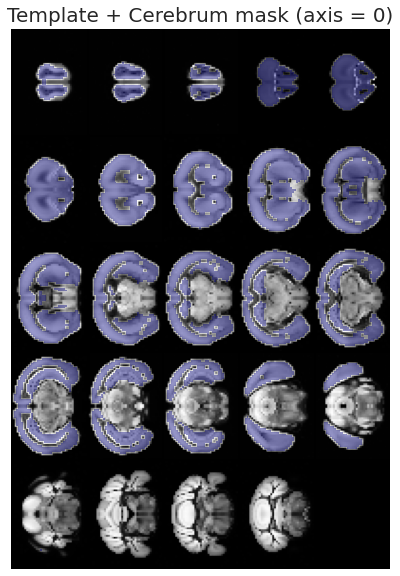

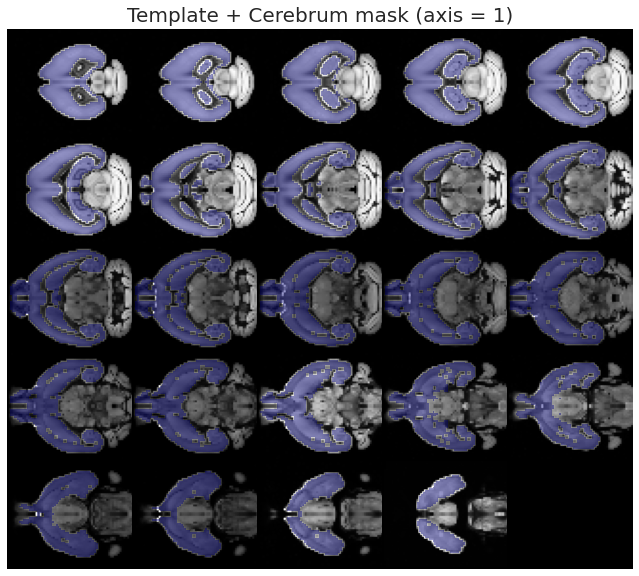

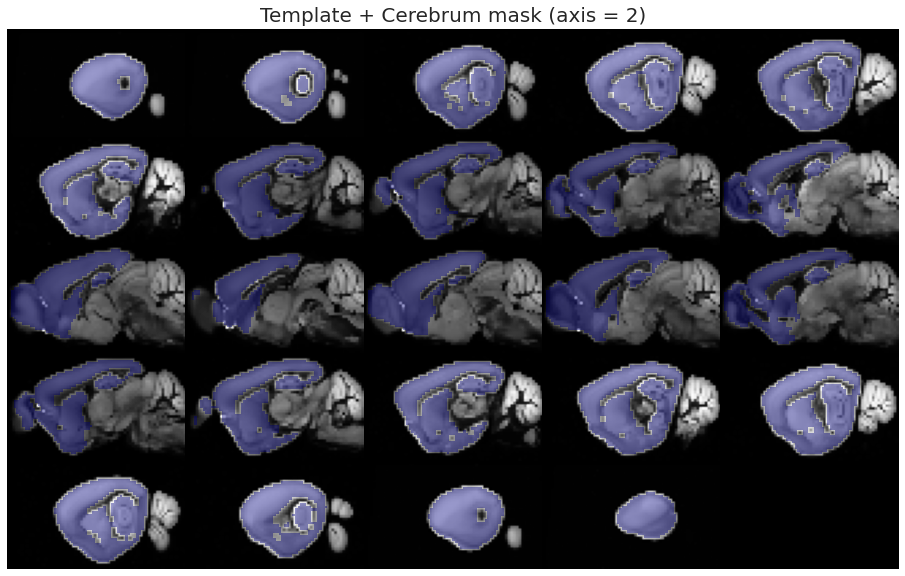

In [24]:
for axis in range(3):
    fixed.plot(
        overlay=CH_mask,
        nslices=24,
        overlay_alpha=0.4,
        axis=axis,
        figsize=1.5,
        reorient=False,
        title='Template + Cerebrum mask (axis = {:d})'.format(axis),
    )

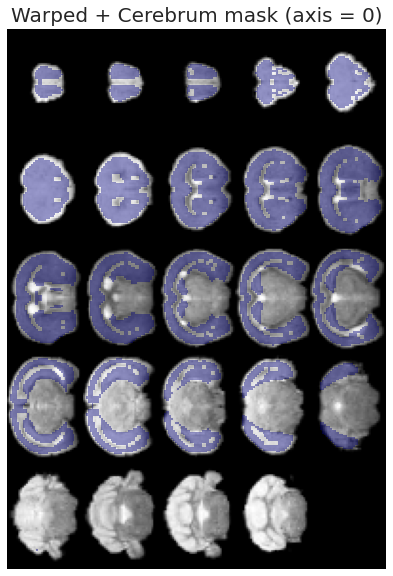

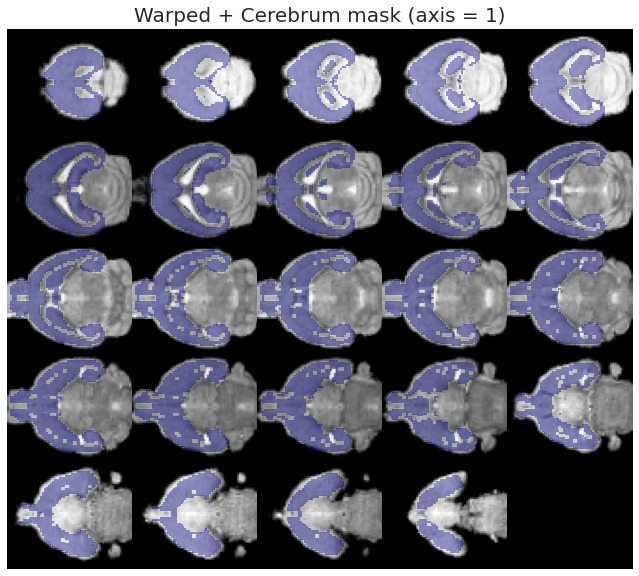

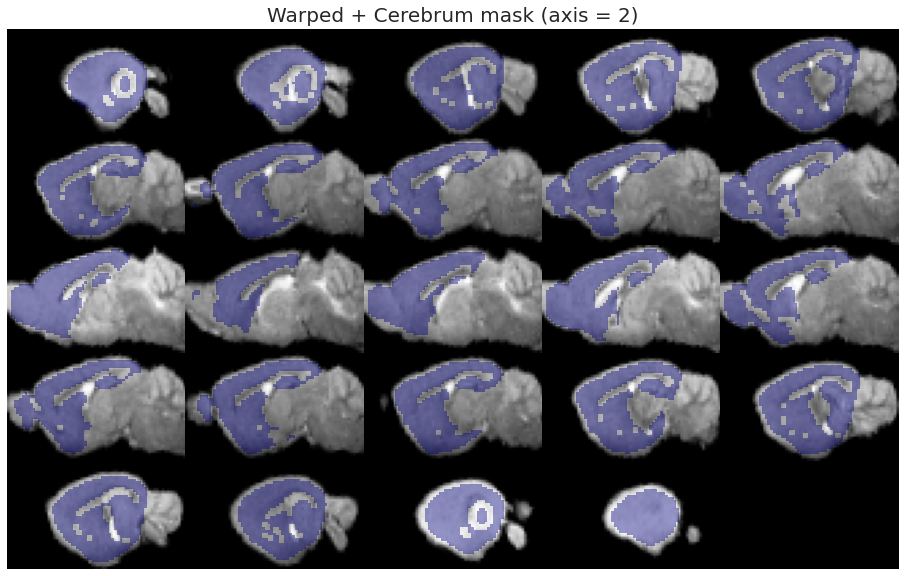

In [25]:
for axis in range(3):
    warped.plot(
        overlay=CH_mask,
        nslices=24,
        overlay_alpha=0.4,
        axis=axis,
        figsize=1.5,
        reorient=False,
        title='Warped + Cerebrum mask (axis = {:d})'.format(axis),
    )

In [76]:
CH_mask_inv = ants.apply_transforms(
    fixed=moving,
    moving=CH_mask,
    transformlist=tx['invtransforms'],
    interpolator='genericLabel',
)

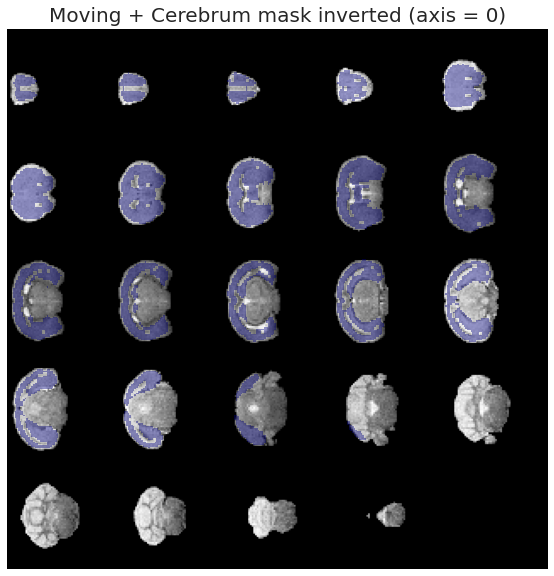

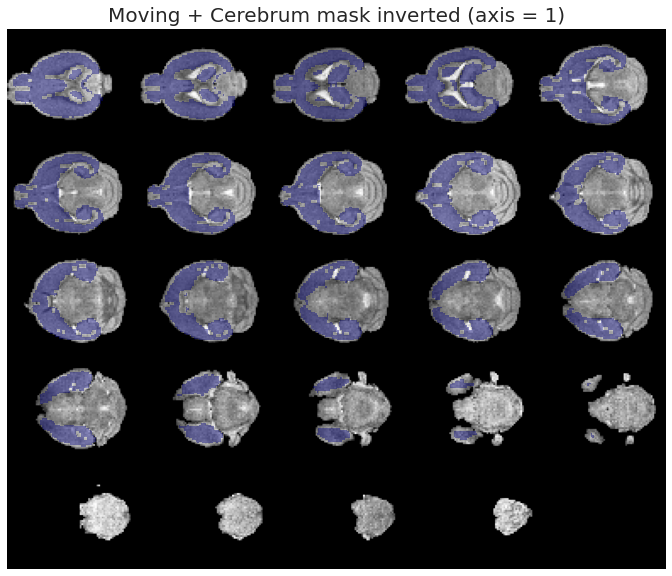

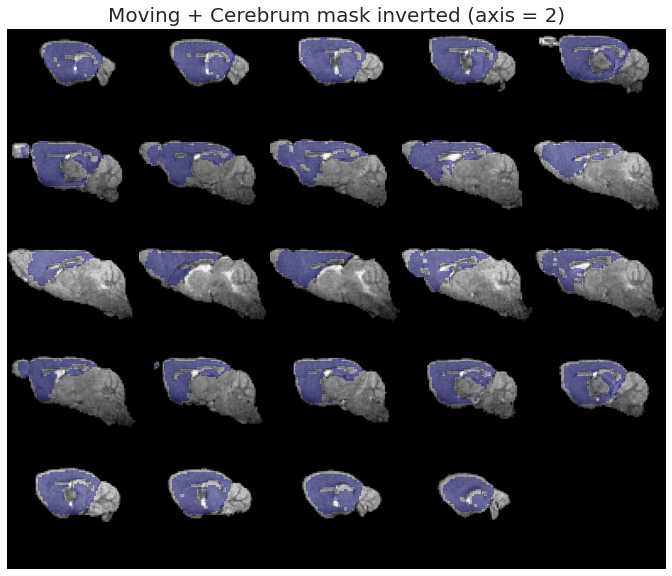

In [77]:
for axis in range(3):
    moving.plot(
        overlay=CH_mask_inv,
        nslices=24,
        overlay_alpha=0.4,
        axis=axis,
        figsize=1.5,
        reorient=False,
        title='Moving + Cerebrum mask inverted (axis = {:d})'.format(axis),
    )

In [1]:
plt.imshow(CH_mask_inv[:].mean(1))
plt.colorbar()

NameError: name 'plt' is not defined

### Apply transform on functional data

In [28]:
config = Config()

func = {}
for subject in tqdm(range(1, config.num_subjects+1), leave=False):
    for session in tqdm(range(1, config.num_sessions+1), leave=False):
        if subject != 6 or session != 1:
            continue
            
        keywords = [
            'sub-SLC{:02d}'.format(subject),
            'ses-{:d}'.format(session),
            'space-individual',
        ]
                
        # func
        for run in range(1, config.num_runs+1):
            kws_func = keywords + ['run-{:d}'.format(run), 'task-rest', 'bold']
            gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_func))
            try:
                func_file = pjoin(config.raw_dir, next(gen))
            except StopIteration:
                continue
                
            _bold = nib.load(func_file).get_fdata().squeeze()
            # bold_reo = []
            for t in range(_bold.shape[-1]):
                slice_reo = ants.reorient_image2(_bold[..., t], orientation='SAR')
            bold_reo = np.concatenate(bold_reo, axis=-1)
            func[run] = ants.from_numpy(bold_reo.astype(float), origin=(0, 0, 0))
        
        # anat
        kws_anat = keywords + ['T1w']
        gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_anat))
        anat_file = pjoin(config.raw_dir, next(gen))
        
        # mask
        kws_mask = keywords + ['desc-mask', 'bold']
        gen = (x for x in sorted(os.listdir(config.raw_dir)) if all(k in x for k in kws_mask))
        mask_file = pjoin(config.raw_dir, next(gen))
        
        # load anat and mask and reorient
        moving = ants.image_read(anat_file, reorient='SAR')
        mask = ants.image_read(mask_file, reorient='SAR')
        
        moving *= mask
        mask = moving.get_mask()
        
# reference image
CH_mask = ants.from_numpy(cerebrum_mask.astype(float), origin=(0, 0, 0))
fixed = ants.from_numpy(template.astype(float), origin=(0, 0, 0))
fixed, CH_mask = [ants.resample_image(img, [2] * 3) for img in [fixed, CH_mask]]

moving, mask, fixed, CH_mask = list(
    ants.from_numpy(img.numpy().astype(float), origin=[0.0] * 3, spacing=[1.0] * 3)
    for img in [moving, mask, fixed, CH_mask]
)

moving.shape, mask.shape, fixed.shape

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

AttributeError: 'numpy.ndarray' object has no attribute 'dimension'

In [53]:
x = ants.reorient_image2(ants.from_numpy(_bold[..., 54]), orientation='SAR')
x = ants.from_numpy(x.numpy().astype(float), origin=[0.0] * 3, spacing=[1.0] * 3)
# x.set_origin([0.0] * 3)
# x.set_spacing([1.0] * 3)

x

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (78, 64, 64)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

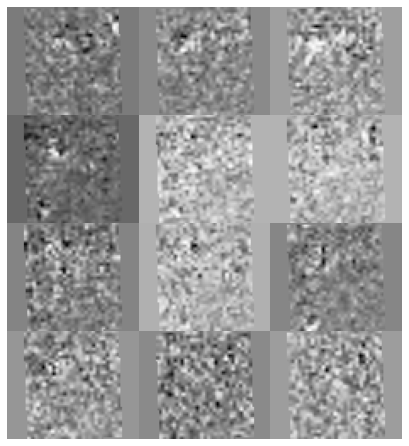

In [60]:
x.plot(axis=2)

In [61]:
y = ants.apply_transforms(
    fixed=fixed,
    moving=x,
    transformlist=tx['fwdtransforms'],
    interpolator='linear',
)
y

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (66, 40, 57)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [62]:
y.plot(axis=0)

AssertionError: Image must be non-zero

In [66]:
mask_inv

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (78, 64, 64)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]